# Content Based 3d Model Retrieval

### Convolutional Neural Networks on 3D models
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

We will be learning on 3D images that are made up of voxels. Simply think pixels, but for 3D.

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

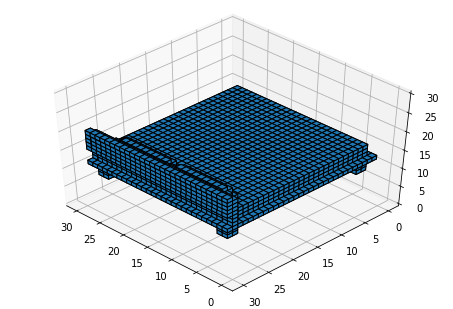

This is a bed.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from data import load_data
from plots import plot_vox

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')

plot_vox(x_train[0].reshape(30, 30, 30)), \
print("This is a {}.".format(target_names[y_train[0]]));

## Evaluate class balance for ModelNet10 and ModelNet40

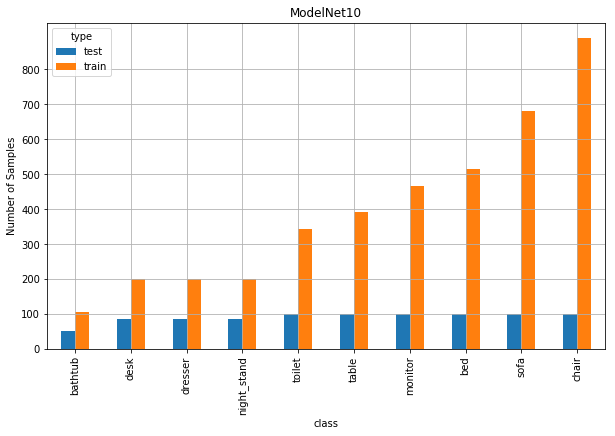

type         test  train
class                   
bathtub        50    106
desk           86    200
dresser        86    200
night_stand    86    200
toilet        100    344
table         100    392
monitor       100    465
bed           100    515
sofa          100    680
chair         100    889

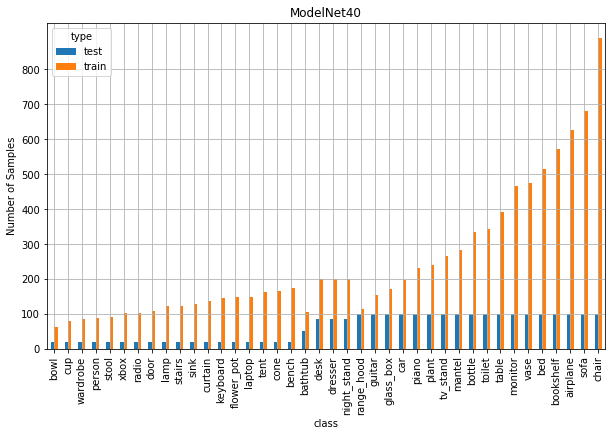

type         test  train
class                   
bowl           20     64
cup            20     79
wardrobe       20     87
person         20     88
stool          20     90
xbox           20    103
radio          20    104
door           20    109
lamp           20    124
stairs         20    124
sink           20    128
curtain        20    138
keyboard       20    145
flower_pot     20    149
laptop         20    149
tent           20    163
cone           20    167
bench          20    173
bathtub        50    106
desk           86    200
dresser        86    200
night_stand    86    200
range_hood    100    115
guitar        100    155
glass_box     100    171
car           100    197
piano         100    231
plant         100    240
tv_stand      100    267
mantel        100    284
bottle        100    335
toilet        100    344
table         100    392
monitor       100    465
vase          100    475
bed           100    515
bookshelf     100    572
airplane      100    626
sofa          100    680
chair         100    889

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from count_files import (make_file_description_data_frame,
                         plot_unbalanced_classes)

df = make_file_description_data_frame('./ModelNet10/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet10')

df = make_file_description_data_frame('./ModelNet40/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet40')

### Class Balance

class to class imbalance is dealt with using upsampling on **only the training data**

We're using stratified sampling to ensure the validation set is representative of the population.

Please look in the plots module if you'd like to see specifically what is going on to accomplish this.

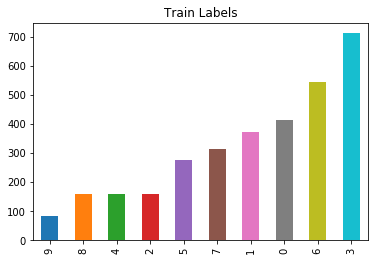

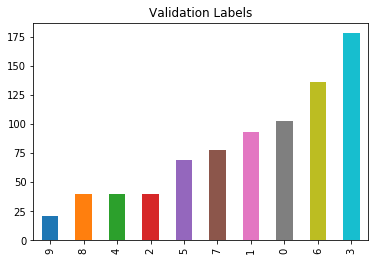

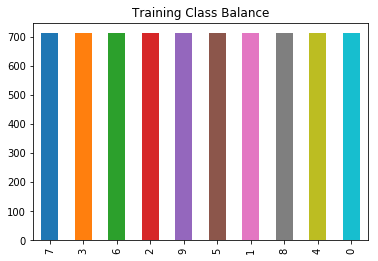

In [1]:
from plots import plot_class_balance
%matplotlib inline

plot_class_balance()

### Build Model
as found in 3DShapeNets paper

In [5]:
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from data import load_data
from plots import plot_vox
from utils import upsample_classes, stratified_shuffle

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
x_train, y_train = upsample_classes(x_train, y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 15, 15, 48)    10416     
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 8, 8, 160)      960160    
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 8, 8, 512)      5243392   
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1200)              314574000 
_________________________________________________________________
dropout_3 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              4804000   
__________

In [12]:
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop


model = Sequential()
model.add(Conv3D(48, 6, strides=2,
                 padding='same',
                 activation='relu',
                 input_shape=(30, 30, 30, 1)))
model.add(Conv3D(160, 5, strides=2,
                 padding='same',
                 activation='relu'))
model.add(Conv3D(512, 4, strides=1,
                 padding='same'))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='softmax'))




optimizer = SGD(lr=0.01, momentum=.7, decay=1e-5, nesterov=True)
model.summary()
model.compile(optimizer,
              'categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 15, 15, 48)    10416     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 8, 160)      960160    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 8, 8, 512)      5243392   
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1200)              314574000 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              4804000   
__________

In [15]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(x_train, y_train,
          epochs=15,
          batch_size=100,
          shuffle=True,
          validation_data=(x_val, y_val),
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

model.evaluate(x_test, y_test)

Train on 8000 samples, validate on 400 samples
Epoch 1/15
8000/8000 [==============================] - 22s 3ms/step - loss: 1.1190 - acc: 0.6636 - val_loss: 0.3112 - val_acc: 0.9025

Epoch 00001: val_loss improved from inf to 0.31117, saving model to weights.best.hdf5
Epoch 2/15
8000/8000 [==============================] - 20s 3ms/step - loss: 0.2882 - acc: 0.9075 - val_loss: 0.2246 - val_acc: 0.9275

Epoch 00002: val_loss improved from 0.31117 to 0.22457, saving model to weights.best.hdf5
Epoch 3/15
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1870 - acc: 0.9393 - val_loss: 0.2065 - val_acc: 0.9300

Epoch 00003: val_loss improved from 0.22457 to 0.20647, saving model to weights.best.hdf5
Epoch 4/15
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1355 - acc: 0.9568 - val_loss: 0.1870 - val_acc: 0.9425

Epoch 00004: val_loss improved from 0.20647 to 0.18699, saving model to weights.best.hdf5
Epoch 5/15
8000/8000 [==============================]

[0.6279980300418984, 0.8645374449339207]

There are regularization steps that I'm not able to recreate. 

In [13]:
model.load_weights('./weights.best.hdf5')

In [14]:
model.evaluate(x_test, y_test)

908/908 [==============================] - 1s 1ms/step


[0.3687363857247493, 0.8843612334801763]

# Where CNN is affected by rotation

CNNs aren't pose invariant. See the plots below

Normal vs Rotated by -90 on (1, 2) axes


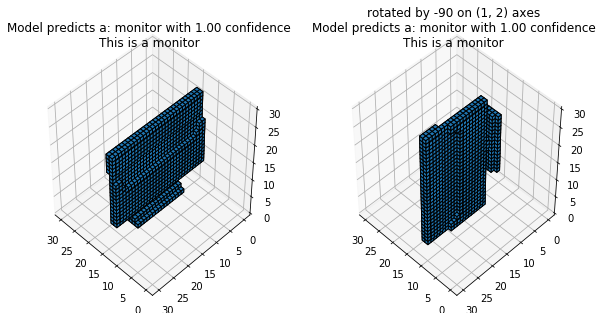

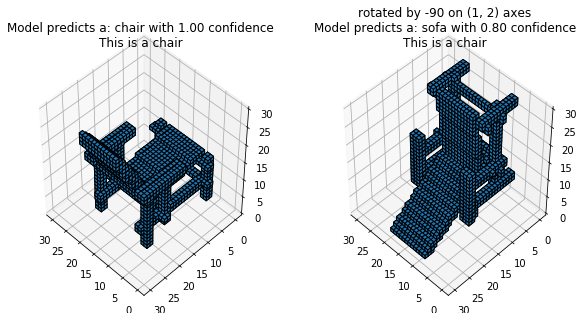

Normal vs Rotated by 90 on (1, 2) axes


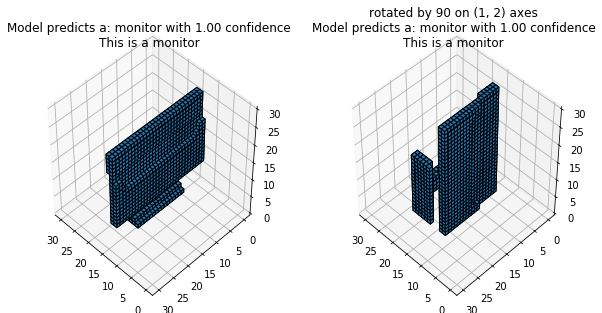

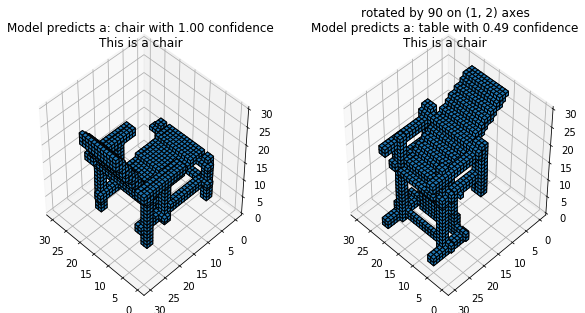

Normal vs Rotated by -90 on (0, 1) axes


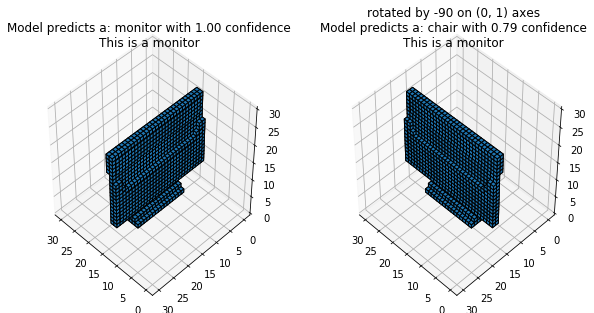

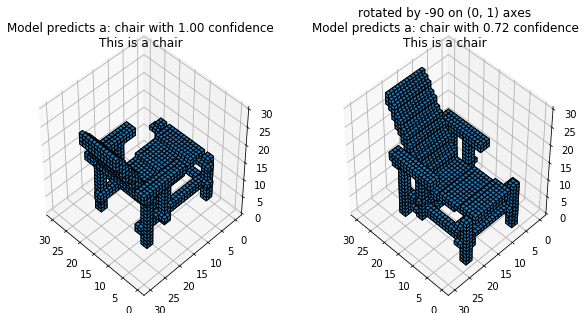

Normal vs Rotated by 90 on (0, 1) axes


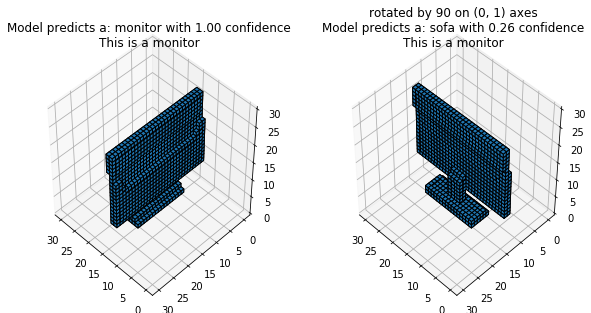

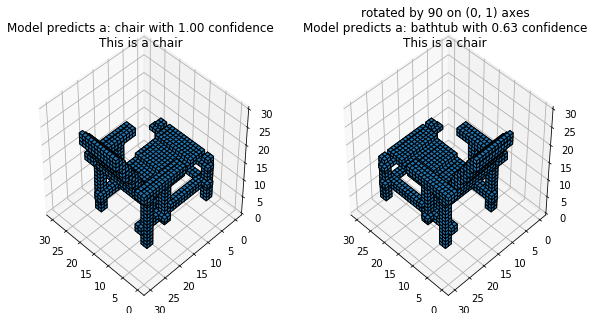

Normal vs Rotated by -90 on (0, 2) axes


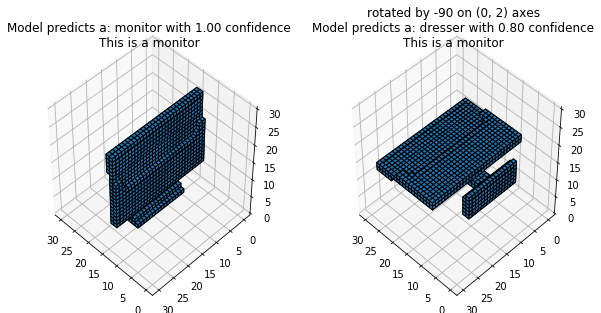

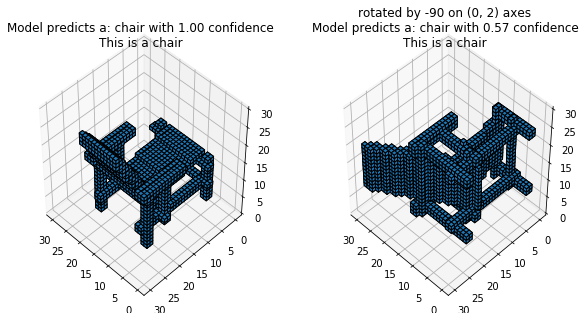

Normal vs Rotated by 90 on (0, 2) axes


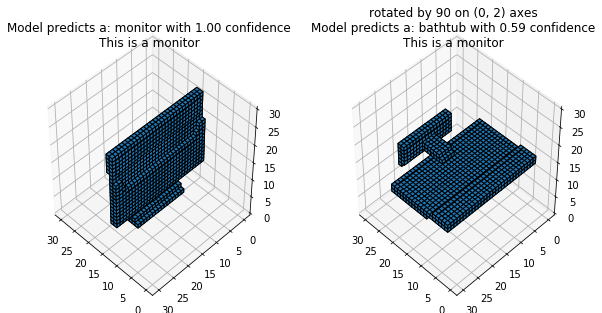

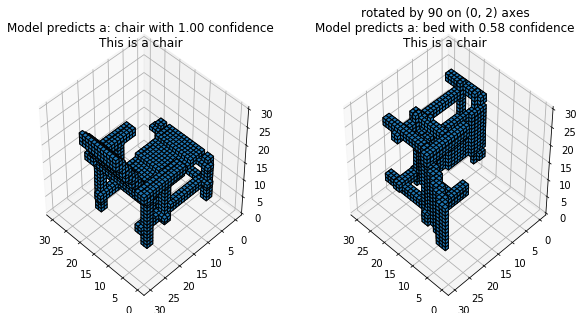

In [14]:
from plots import plot_rotation_issue
poses = [
    (-90, (1, 2)),
    (90, (1, 2)),
    (-90, (0, 1)),
    (90, (0, 1)),
    (-90, (0, 2)),
    (90, (0, 2))
]
for rot, axes in poses:
    print('Normal vs Rotated by {} on {} axes'.format(rot, axes))
    plot_rotation_issue(x_test[100:101], y_test[100],
                        target_names, model, rot, axes)
#     plot_rotation_issue(x_test[300:301], y_test[300],
#                         target_names, model, rot, axes)

You can see that the monitor does ok for axes that keep the majority of the monitor's 'flatness' within the same bounds as the normal model. But, as soon as you rotate it in an axis that pulls the monitor out of the largest bound (the direction when you tip it down onto its face) you see the confidence go way down. 

The same is true for the chair. The chair isn't really necessary in order to see what's happening, but it seems prudent to include it so we know this isn't singular to the monitor model. 

### Time to actually try out Capsule Nets

Now that we've shown that CNNs aren't pose invariant, it's now time to do what we've all been waiting for... IMPLEMENT Capsule Nets!

In [1]:
import numpy as np
# from keras import layers, models, optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Conv3D, Dense, Reshape, Add, Input
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image

from utils import combine_images
from capsulenet import margin_loss
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

from data import load_data
from plots import plot_vox, plot_capsnet_rotation_issue, plot_rotation_issue
from utils import upsample_classes, stratified_shuffle

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [40]:
(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
x_train, y_train = upsample_classes(x_train, y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [3]:
n_class = y_test.shape[1]
input_shape = (30, 30, 30, 1)
dim_sub_capsule=24
dim_primary_capsule=12

x = Input(shape=(30, 30, 30, 1))


conv1 = Conv3D(filters=48, kernel_size=9, strides=1,
               padding='valid', activation='relu', name='conv1')(x)


# primarycaps = PrimaryCap(conv1, dim_capsule=12, n_channels=32,
#                          kernel_size=9, strides=2, padding='valid')

primarycaps = PrimaryCap(conv1, dim_capsule=dim_primary_capsule, n_channels=32,
                         kernel_size=9, strides=2, padding='valid')

sub_caps = CapsuleLayer(num_capsule=n_class, dim_capsule=dim_sub_capsule,
                         routings=3, name='sub_caps')(primarycaps)


out_caps = Length(name='capsnet')(sub_caps)


y = Input(shape=(n_class,))
masked_by_y = Mask()([sub_caps, y])

masked = Mask()(sub_caps)

decoder = Sequential(name='decoder')
decoder.add(Dense(512, activation='relu',
                  input_dim=dim_sub_capsule*n_class))
decoder.add(Dense(1024, activation='relu'))
decoder.add(Dense(np.prod(input_shape), activation='sigmoid'))

decoder.add(Reshape(target_shape=input_shape, name='out_recon'))

train_model = Model([x, y], [out_caps, decoder(masked_by_y)])


eval_model = Model(x, [out_caps, decoder(masked)])



### manipulate model
noise = Input(shape=(n_class, dim_sub_capsule))
noised_sub_caps = Add()([sub_caps, noise])
masked_noised_y = Mask()([noised_sub_caps, y])
manipulate_model = Model([x, y, noise], decoder(masked_noised_y))

Instructions for updating:
dim is deprecated, use axis instead


In [4]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 30, 30, 1 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 22, 22, 22, 4 35040       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv3d (Conv3D)      (None, 7, 7, 7, 384) 13437312    conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 10976, 12)    0           primarycap_conv3d[0][0]          
__________________________________________________________________________________________________
primarycap

train_model

In [5]:
# optimizer = SGD(lr=0.001, momentum=.7, decay=1e-5, nesterov=True)
optimizer = Adam(lr=0.001)
lam_recon = .392
train_model.compile(optimizer,
                    loss=[margin_loss, 'mse'],
                    loss_weights=[1., lam_recon],
                    metrics={'capsnet': 'accuracy'})


checkpointer = ModelCheckpoint(filepath='capsnets.weights.best.hdf5',
                               verbose=1, save_best_only=True)
tb = TensorBoard(log_dir='./tensor_board.log/')

In [6]:
train_model.fit([x_train, y_train], [y_train, x_train],
                batch_size=64, epochs=10,
                validation_data=[[x_val, y_val], [y_val, x_val]],
                callbacks=[checkpointer, tb])

Train on 8000 samples, validate on 400 samples
Epoch 1/10
8000/8000 [==============================] - 156s 19ms/step - loss: 0.5008 - capsnet_loss: 0.4493 - decoder_loss: 0.1315 - capsnet_acc: 0.5440 - val_loss: 0.1583 - val_capsnet_loss: 0.1288 - val_decoder_loss: 0.0754 - val_capsnet_acc: 0.8675

Epoch 00001: val_loss improved from inf to 0.15835, saving model to capsnets.weights.best.hdf5
Epoch 2/10
8000/8000 [==============================] - 143s 18ms/step - loss: 0.1101 - capsnet_loss: 0.0798 - decoder_loss: 0.0772 - capsnet_acc: 0.9289 - val_loss: 0.1214 - val_capsnet_loss: 0.0941 - val_decoder_loss: 0.0698 - val_capsnet_acc: 0.9100

Epoch 00002: val_loss improved from 0.15835 to 0.12143, saving model to capsnets.weights.best.hdf5
Epoch 3/10
8000/8000 [==============================] - 144s 18ms/step - loss: 0.0691 - capsnet_loss: 0.0411 - decoder_loss: 0.0714 - capsnet_acc: 0.9699 - val_loss: 0.1007 - val_capsnet_loss: 0.0745 - val_decoder_loss: 0.0670 - val_capsnet_acc: 0.920

Stopped training since train set accuracy went all the way to 1.0 but val setn ever went higher than .935

In [4]:
train_model.load_weights('capsnets.weights.best.hdf5')

In [5]:
y_pred, x_recon = eval_model.predict(x_test)

In [6]:
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

Test acc: 0.8535242290748899


##### Let's look at rotation issue for Capsnets

REGULAR CNN


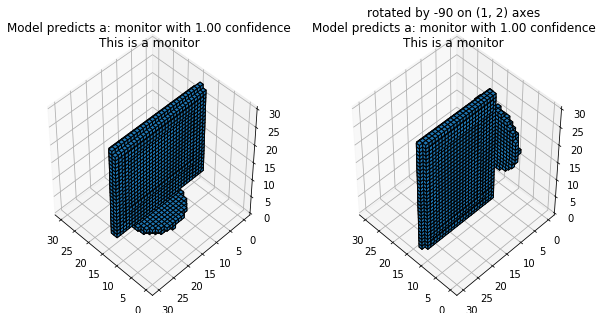

CAPSNET


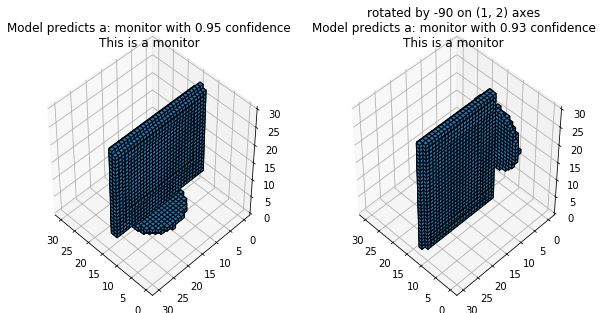

REGULAR CNN


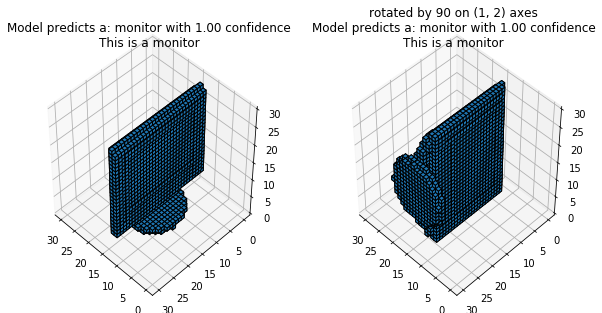

CAPSNET


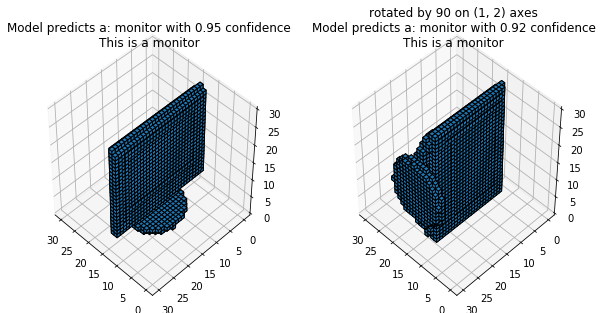

REGULAR CNN


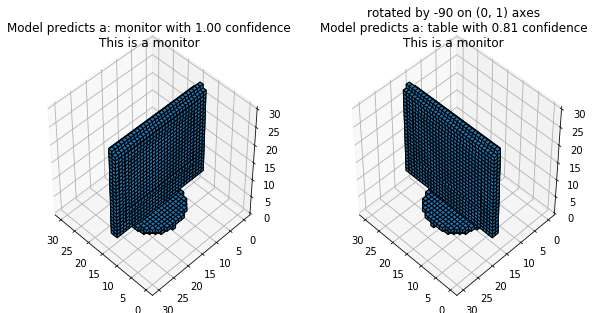

CAPSNET


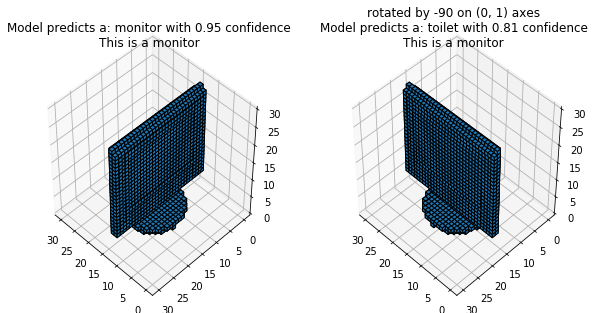

REGULAR CNN


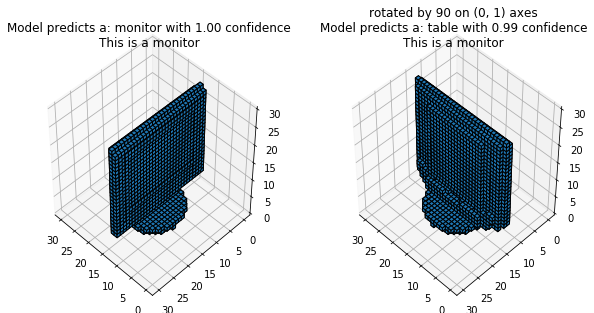

CAPSNET


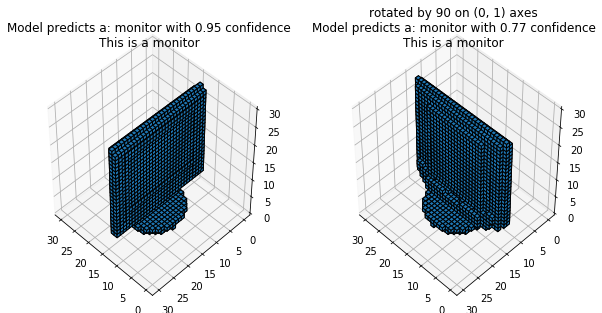

REGULAR CNN


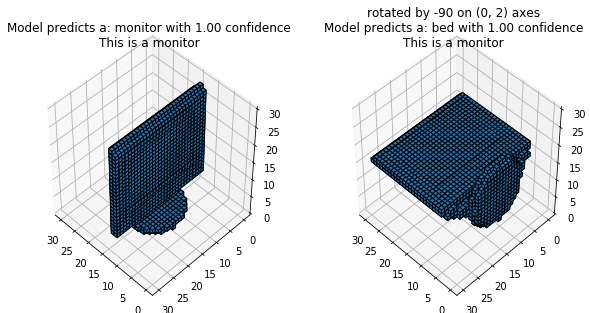

CAPSNET


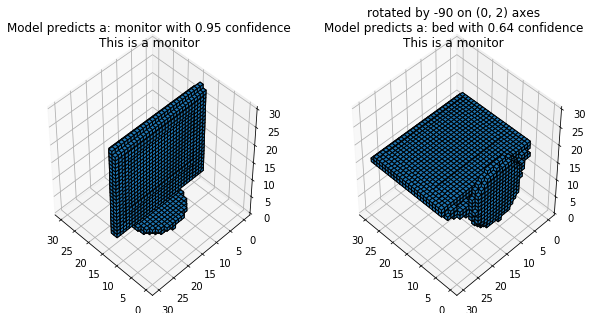

REGULAR CNN


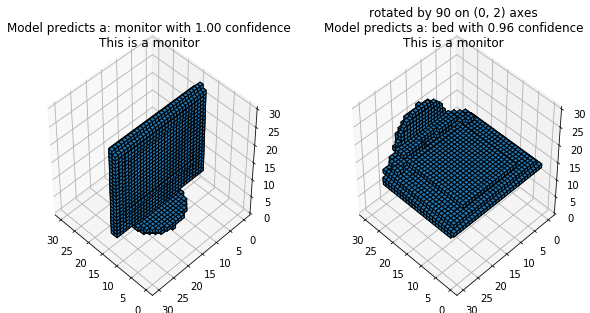

CAPSNET


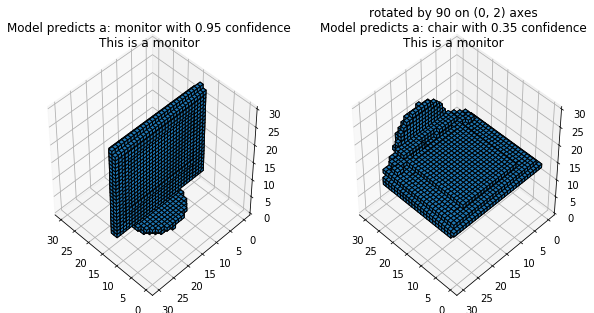

In [15]:
poses = [
    (-90, (1, 2)),
    (90, (1, 2)),
    (-90, (0, 1)),
    (90, (0, 1)),
    (-90, (0, 2)),
    (90, (0, 2))
]
for rot, axes in poses:
    print('REGULAR CNN')
    plot_rotation_issue(x_test[100:101], y_test[100],
                        target_names, model, rot, axes)    
    print('CAPSNET')
    plot_capsnet_rotation_issue(x_test[100:101], y_test[100],
                        target_names, eval_model, rot, axes)    
#     plot_capsnet_rotation_issue(x_test[300:301], y_test[300],
#                         target_names, eval_model, rot, axes)

Well that isn't much better now is it? One thing that is better is if you look at when they're wrong, are they less confident?.  The capsnet appears to be less confident when it is wrong. This is a good thing!  When the CNN is wrong it is sometimes saying 100% this is a toilet.  Whereas the Capsnet says 81% this is a toilet. 

Still need some improvement. But mind you, this is almost exactly the same architecture that was used in capsnets for MNIST by xifengGuo. That is just nuts. 

### manipulate the latent model (or content based info retrieval this is necessary)

In [41]:
index = np.argmax(y_test, 1) == 0

In [42]:
number = np.random.randint(0, sum(index) - 1)

In [136]:
x_manipulate, y_manipulate = x_test[index][number], y_test[index][number]
x_manipulate, y_manipulate = np.expand_dims(x_manipulate, 0), np.expand_dims(y_manipulate, 0)

noise = np.zeros([1, n_class, dim_sub_capsule])

x_recons = []

for dim in range(dim_sub_capsule):
    for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
        tmp = np.copy(noise)
        tmp[:,:,dim] = r
        x_recon = manipulate_model.predict([x_manipulate, y_manipulate, tmp])
        x_recons.append(x_recon)

x_recons = np.concatenate(x_recons)

In [142]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
x_recons[0].shape

(30, 30, 30, 1)

### Look at features the capsnet extracted

This are supposed to be much more straight forward and interpretable. 

In [139]:
from matplotlib import cm

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

In [140]:
colors = np.array([[['#1f77b430']*30]*30]*30)
colors = explode(colors)
filled = explode(np.ones((30, 30, 30)))
facecolors = cm.gray(x_recons[0].reshape(30, 30, 30))
facecolors[:, :, :, -1] = x_recon[0].reshape(30, 30, 30)
facecolors = explode(facecolors)

In [150]:
filled = facecolors[:, :, :, -1] > 0.1
# filled = facecolors[:, :, :, -1] != 0
x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

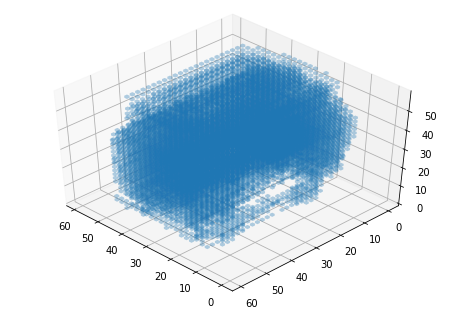

In [151]:
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(45, 135)
# tmp = dense_to_sparse(x_recons[0].reshape(30, 30, 30))
# ax.scatter3D(tmp[0], tmp[1], tmp[2])
# ax.voxels(x_recons[0].reshape(30, 30, 30), facecolors='#1f77b430', edgecolors='gray');
ax.voxels(filled, facecolors=colors);

Ok well there's something.  I need to com back to this

Follow this tutorial to plot voxels with various shadings: https://terbium.io/2017/12/matplotlib-3d/

# Appendix

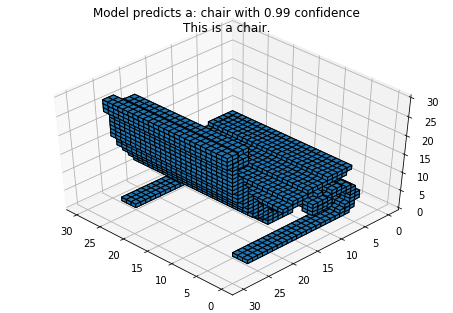

In [28]:
from plots import plot_vox

def plot_model_guess(num):
    truth = target_names[np.argmax(y_test[num])]
    proba = model.predict(x_test[num].reshape(1, 30, 30, 30, 1))
    proba_idx = np.argmax(proba)
    predicted_name = target_names[proba_idx]
    plot_vox(x_test[num].reshape(30, 30, 30),
             title='Model predicts a: {1} with {2:.2f} confidence\nThis is a {0}.'\
              .format(truth, predicted_name, proba[0][proba_idx]))
#     print('this is a {}'.format(target_names[np.argmax(y_test[num])]))
#     proba = model.predict(x_test[num].reshape(1, 30, 30, 30, 1))
#     predicted_name = target_names[np.argmax(proba)]
#     print('the model predicts a {}'.format(predicted_name))

plot_model_guess(350)

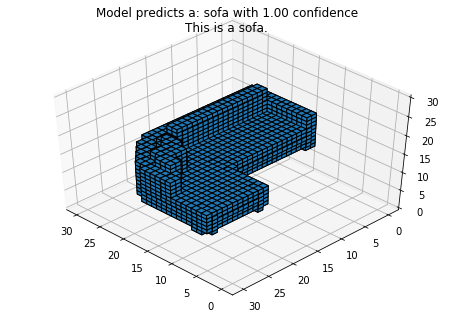

In [29]:
plot_model_guess(0)

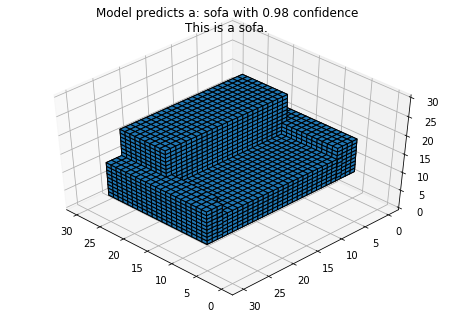

In [30]:
plot_model_guess(80)

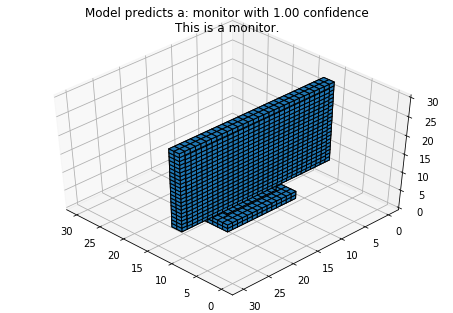

In [31]:
plot_model_guess(160)

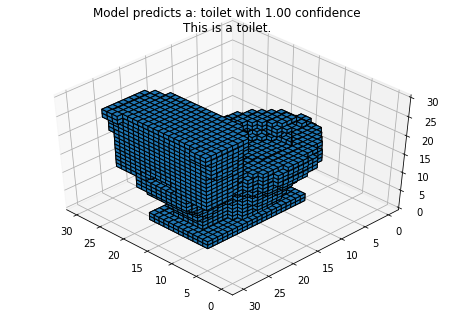

In [32]:
plot_model_guess(240)

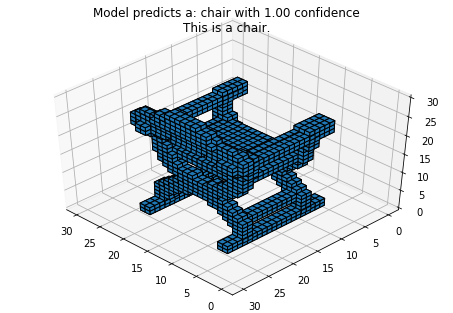

In [33]:
plot_model_guess(320)

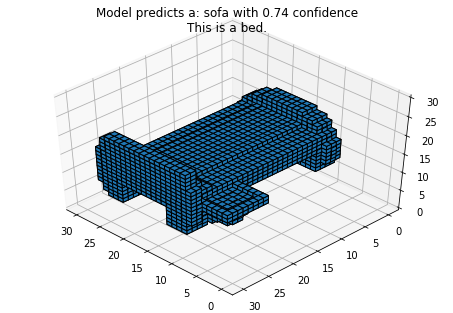

In [34]:
plot_model_guess(400)

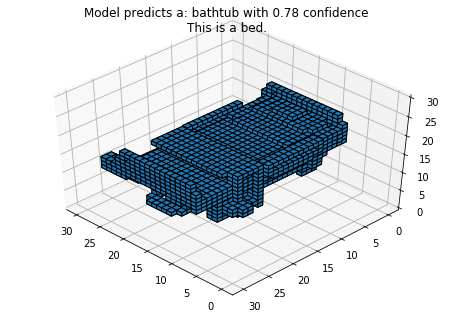

In [35]:
plot_model_guess(480)

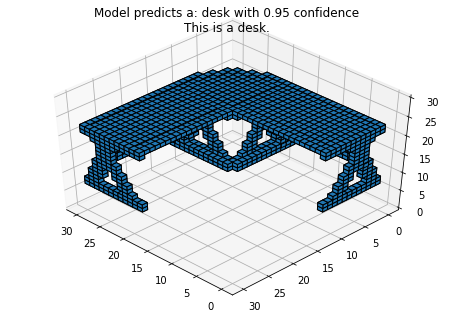

In [36]:
plot_model_guess(560)

WRONG! :-D

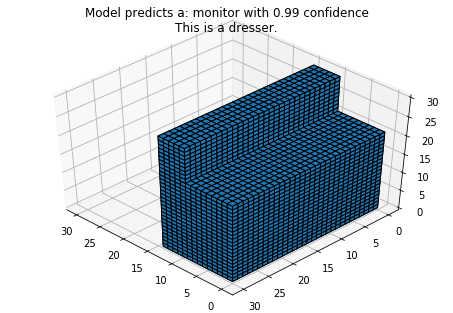

In [37]:
plot_model_guess(640)

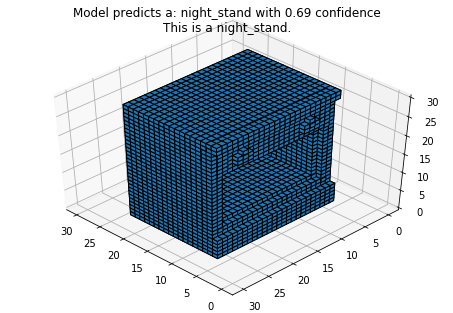

In [38]:
plot_model_guess(720)

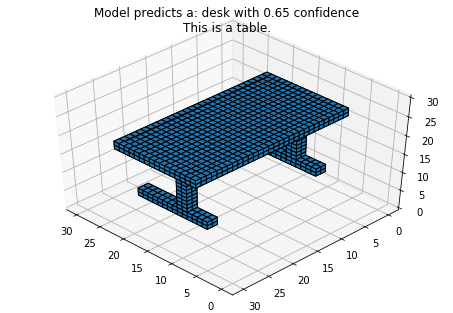

In [39]:
plot_model_guess(800)

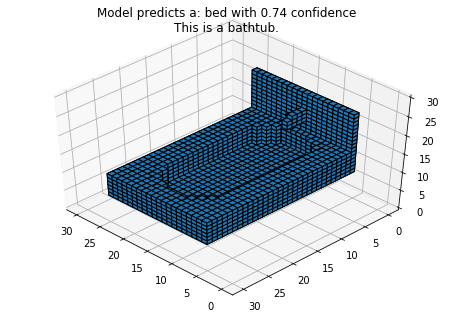

In [41]:
plot_model_guess(880)